# Wind Power Prediction using Stochastic Gradient Descent (SGD)

This notebook demonstrates the process of training and evaluating a neural network model for wind power prediction using Stochastic Gradient Descent (SGD) optimization.

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the parent directory to the Python path
sys.path.append('..')

from src.data import load_data
from src.models import create_and_compile_sgd_model
from src.sgd_optimizer import sgd_pipeline
from src.utils import set_seeds, create_results_directory
from src.visualization import plot_predictions, plot_feature_importance

2024-10-18 01:43:21.951293: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 01:43:21.958453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 01:43:21.966034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 01:43:21.968281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 01:43:21.975040: I tensorflow/core/platform/cpu_feature_guar

## 1. Set up the environment

In [3]:
# Set random seeds for reproducibility
set_seeds(42)

# Create a results directory
results_dir = create_results_directory()
print(f"Results will be saved in: {results_dir}")

2024-10-18 01:43:24,685 - INFO - Random seeds set to 42
2024-10-18 01:43:24,685 - INFO - Results directory created: /home/dkat/computational-intelligence/src/../results/20241018_014324


Results will be saved in: /home/dkat/computational-intelligence/src/../results/20241018_014324


## 2. Load and preprocess data

In [4]:
# Load the data
(train_X, train_y), (val_X, val_y), (test_X, test_y), scaler_X, scaler_y = load_data()

print("Data shapes:")
print(f"Train: {train_X.shape}, {train_y.shape}")
print(f"Validation: {val_X.shape}, {val_y.shape}")
print(f"Test: {test_X.shape}, {test_y.shape}")

2024-10-18 01:43:26,874 - INFO - Loading data from ../data/raw/Train.csv
2024-10-18 01:43:26,959 - INFO - Train data shape: (140160, 12)
2024-10-18 01:43:26,962 - INFO - Input columns: ['Temp_2m', 'RelHum_2m', 'DP_2m', 'WS_10m', 'WS_100m', 'WD_10m', 'WD_100m', 'WG_10m']
2024-10-18 01:43:26,962 - INFO - Output column: Power
2024-10-18 01:43:26,975 - INFO - Training set shape: (98112, 9)
2024-10-18 01:43:26,975 - INFO - Validation set shape: (21024, 9)
2024-10-18 01:43:26,975 - INFO - Test set shape: (21024, 9)
2024-10-18 01:43:26,984 - INFO - Data scaling completed


Data shapes:
Train: (98112, 8), (98112, 1)
Validation: (21024, 8), (21024, 1)
Test: (21024, 8), (21024, 1)


## 3. Create and compile the model

In [5]:
# Define model architecture
input_shape = (train_X.shape[1],)
layer_sizes = [256, 128, 64]

# Create and compile the model
model = create_and_compile_sgd_model(input_shape, layer_sizes)
model.summary()

/home/dkat/computational-intelligence/venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1729215809.612379  417668 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729215809.625809  417668 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729215809.625844  417668 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729215809.628017  417668 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,521 (170.00 KB)

 Trainable params: 43,521 (170.00 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train and evaluate the model

2024-10-18 01:43:33,560 - INFO - Starting SGD pipeline
2024-10-18 01:43:33,561 - INFO - Starting model training with SGD


Epoch 1/1000


I0000 00:00:1729215813.902357  417847 service.cc:146] XLA service 0x7fd65c004670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729215813.902381  417847 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-10-18 01:43:33.916858: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-18 01:43:33.957531: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 223/3066 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - loss: 0.8034

I0000 00:00:1729215814.690443  417847 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3066/3066 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6233 - val_loss: 0.5122 - learning_rate: 0.0010
Epoch 2/1000
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 836us/step - loss: 0.5296 - val_loss: 0.5021 - learning_rate: 0.0010
Epoch 3/1000
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 2s 795us/step - loss: 0.5182 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 4/1000
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 2s 787us/step - loss: 0.5102 - val_loss: 0.4936 - learning_rate: 0.0010
Epoch 5/1000
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 2s 782us/step - loss: 0.5067 - val_loss: 0.4903 - learning_rate: 0.0010
Epoch 6/1000
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 2s 784us/step - loss: 0.5019 - val_loss: 0.4892 - learning_rate: 0.0010
Epoch 7/1000
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step - loss: 0.5004 - val_loss: 0.4857 - learning_rate: 0.0010
Epoch 8/1000
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 2s 802us/step - loss: 0.4968 - val_loss: 0.4849 - learning_rate: 0.0010
Epoch 9/1000
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 864us/step - loss: 0.4965 - val_loss: 0.

2024-10-18 02:04:20,446 - INFO - Model training completed
2024-10-18 02:04:20,447 - WARNING - Seaborn style not found. Using default style.
2024-10-18 02:04:20,448 - INFO - Plot style set
2024-10-18 02:04:20,532 - INFO - Training history plot saved to /home/dkat/computational-intelligence/src/../results/20241018_014324/sgd_training_history.png


2024-10-18 02:04:20,537 - INFO - Model summary saved to /home/dkat/computational-intelligence/src/../results/20241018_014324/sgd_model_summary.txt
2024-10-18 02:04:20,537 - INFO - Experiment parameters logged to /home/dkat/computational-intelligence/src/../results/20241018_014324/sgd_experiment_params.txt
2024-10-18 02:04:20,537 - INFO - Evaluating model on test data


657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step


2024-10-18 02:04:21,371 - INFO - Test MSE: 0.0264
2024-10-18 02:04:21,372 - INFO - Test RMSE: 0.1626
2024-10-18 02:04:21,372 - INFO - Test R2 Score: 0.5869
2024-10-18 02:04:21,372 - WARNING - Seaborn style not found. Using default style.
2024-10-18 02:04:21,373 - INFO - Plot style set
2024-10-18 02:04:21,933 - INFO - Predictions plot saved to /home/dkat/computational-intelligence/src/../results/20241018_014324/sgd_predictions.png
2024-10-18 02:04:21,934 - INFO - Experiment parameters logged to /home/dkat/computational-intelligence/src/../results/20241018_014324/sgd_evaluation_metrics.txt
2024-10-18 02:04:21,934 - INFO - SGD pipeline completed



Evaluation Results:
Test MSE: 0.0264
Test RMSE: 0.1626
Test R2 Score: 0.5869


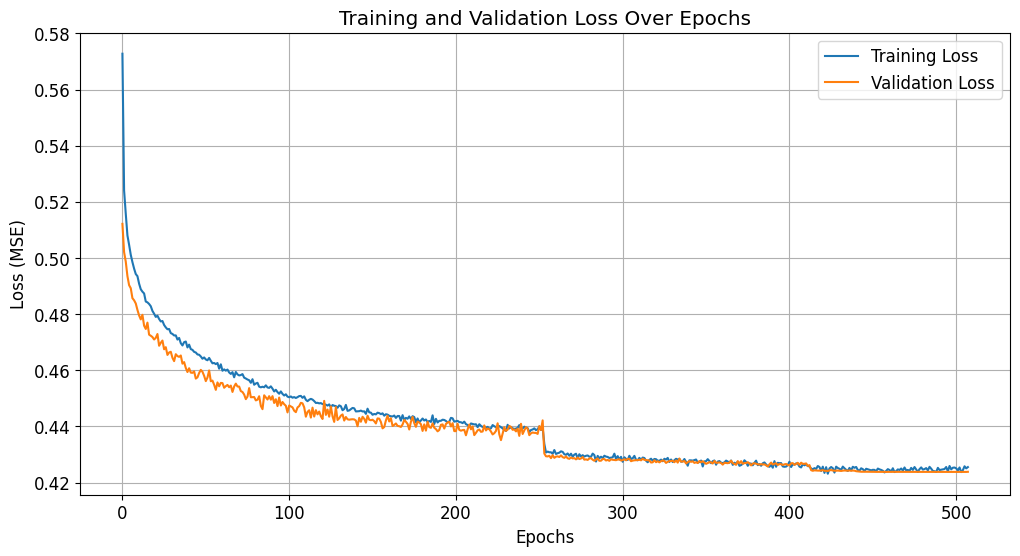

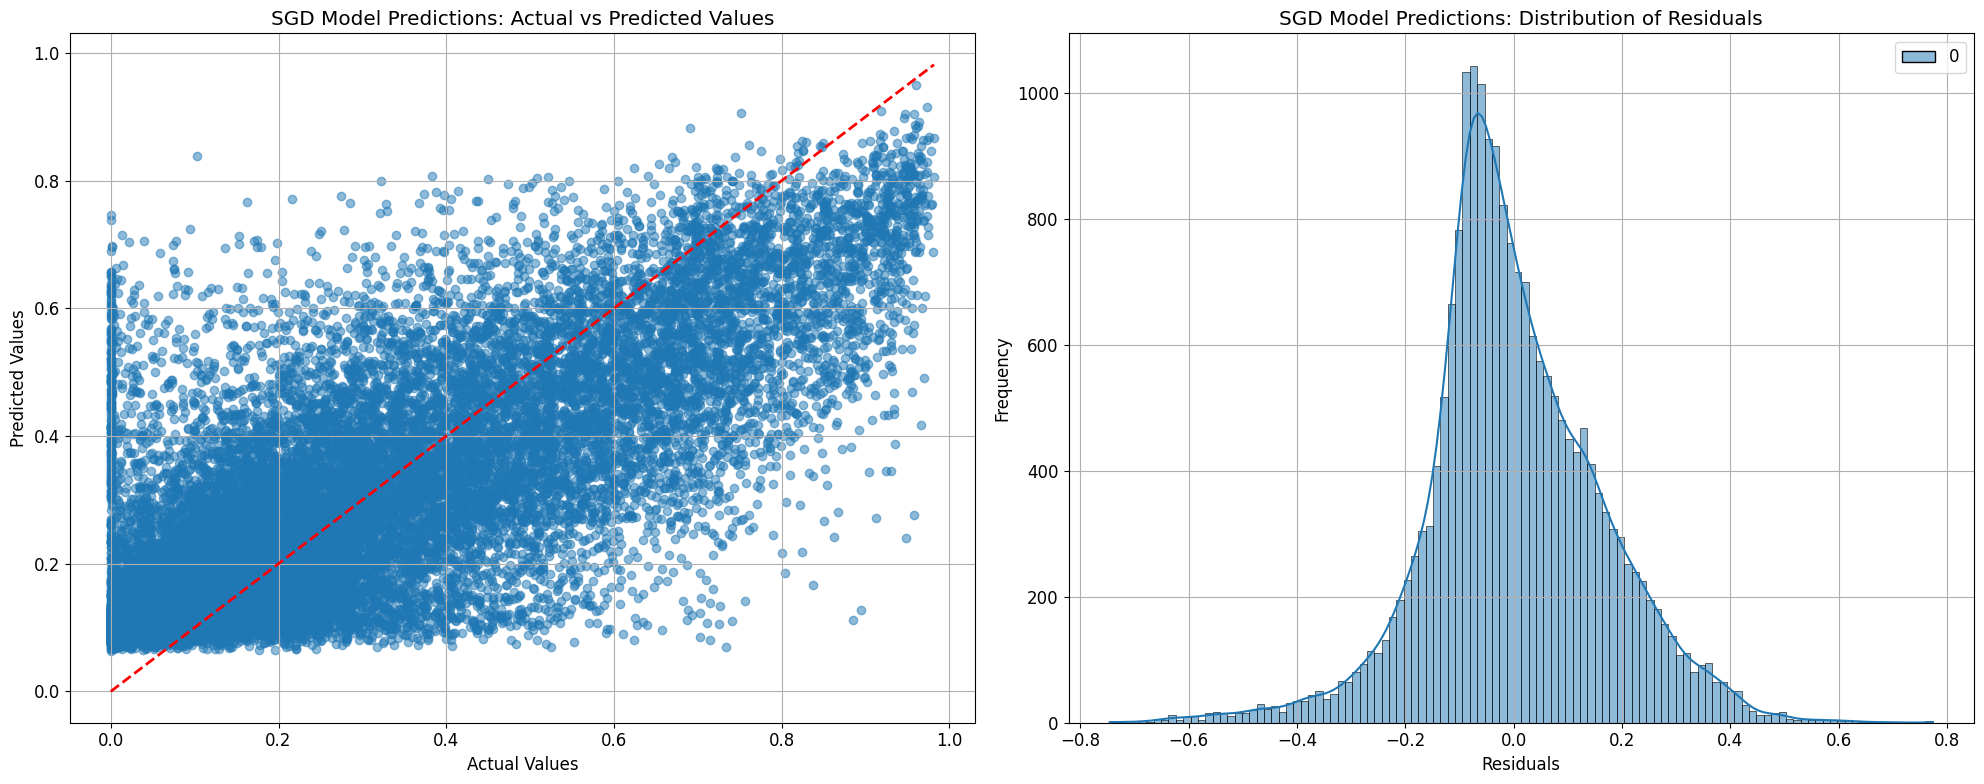

In [6]:
# Set training parameters
params = {
    "epochs": 1000,
    "batch_size": 32,
    "patience": 50,
    "min_delta": 1e-4,
    "min_lr": 1e-6,
    "factor": 0.1
}

# Run SGD pipeline
history, eval_results = sgd_pipeline(
    model, 
    (train_X, train_y), 
    (val_X, val_y), 
    (test_X, test_y), 
    scaler_y,
    **params,
    results_dir=results_dir
)

print("\nEvaluation Results:")
print(f"Test MSE: {eval_results['mse']:.4f}")
print(f"Test RMSE: {eval_results['rmse']:.4f}")
print(f"Test R2 Score: {eval_results['r2']:.4f}")

## 5. Conclusion

In this notebook, we have:
1. Loaded and preprocessed the wind power prediction data.
2. Created and compiled a neural network model optimized with SGD.
3. Trained the model using early stopping and learning rate reduction.
4. Evaluated the model's performance on the test set.
5. Visualized the predictions and analyzed the learning curves.

The model achieved an RMSE of 0.1626 and an R2 score of 0.5869 on the test set.

Further improvements could potentially be made by:
- Experimenting with different model architectures
- Trying different hyperparameters
- Applying more advanced regularization techniques
- Incorporating additional relevant features if available